### ***Setup***

In [1]:
data_PATH = "./assets/original/CSV_Files/AODBData_2017_2022.csv"
weather_JSON_PATH = "./assets/original/JSON_Files/weather.json"
airports_JSON_PATH = "./assets/original/JSON_Files/airports.json"
result_PATH = "./assets/generated/res.csv"
analysis_notebook_PATH = "./assets/generated/analysis_result.csv"
model_weights_PATH = "./assets/generated/model_weights/"


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

In [3]:
from data_preprocessing.Cleaner import Cleaner
from data_preprocessing.WeatherCollector import WeatherCollector
from data_preprocessing.FeatureExtractor import FeatureExtractor
from data_preprocessing.FeaturePreProcessing import FeaturePreProcessing
from data_preprocessing.CustomizeData import CustomizeData
from models.NeuralNetwork import NeuralNetwork
from models.RandomForest import RandomForest
from utils import *

In [30]:
DATASET = pd.read_csv(data_PATH, index_col=False, parse_dates=['ETOA', 'ETOD'])
DATASET

C:\Users\Admin\AppData\Local\Temp\ipykernel_4696\4156636361.py:1: DtypeWarning: Columns (7,9,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  DATASET = pd.read_csv(data_PATH, index_col=False, parse_dates=['ETOA', 'ETOD'])


,Arr_FlightNo,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,TMOA,...,On_Block,Dep_FlightNo,Dep_Callsign,Destination,Dep_ParkingStand,STOD,Gate,ETOD,Off_Block,Actual_Takeoff
0,SG 059,SEJ059,TCTJT,B738,VOML,C55L,PS,4,2.016123e+13,20161231223400,...,20161231224627,SG 058,SEJ058,VIJP,C55L,2.016123e+13,D12,20161231234000,2.016123e+13,2.017010e+13
1,EK 603,UAE603,A6ENC,B77W,OPKC,B23,PS,301,2.016123e+13,20161231212800,...,20161231213808,EK 041,UAE041,EGBB,B23,2.016123e+13,B24,20161231234500,2.016123e+13,2.017010e+13
2,EK 202,UAE202,A6EDM,A388,KJFK,F18,PS,304,2.016123e+13,20161231161837,...,20161231162700,EK 306,UAE306,ZBAA,F18,2.016123e+13,B13,20161231235000,2.016123e+13,2.017010e+13
3,EK 094,UAE094,A6EPB,B77W,LIPE,B24,PS,304,2.016123e+13,20161231221000,...,20161231221900,EK 388,UAE388,VVNB,B24,2.016123e+13,B26,20170101000000,2.016123e+13,2.017010e+13
4,EK 752,UAE752,A6EPI,B77W,GMMN,D03,PS,306,2.016123e+13,20161231213000,...,20161231213731,EK 101,UAE101,LIMC,D03,2.016123e+13,A10,20170101000000,2.016123e+13,2.017010e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974248,EK 020,UAE1C,A6EVA,A388,EGCC,A07,PS,305.0,2.022123e+13,20221231040245,...,20221231041123,EK 011,UAE9KC,EGKK,A07,2.022123e+13,A23,20221231233500,2.022123e+13,2.022123e+13
974249,EK 074,UAE65W,A6EVL,A388,LFPG,F08,PS,310.0,2.022123e+13,20221231194142,...,20221231195130,EK 362,UAE362,ZGGG,F08,2.022123e+13,C13,20221231232500,2.022123e+13,2.022123e+13
974250,EK 050,UAE8VC,A6EON,A388,EDDM,D08,PS,301.0,2.022123e+13,20221231194258,...,20221231195335,EK 231,UAE3MX,KIAD,D08,2.022123e+13,A15,20221231233500,2.022123e+13,2.022123e+13
974251,EK 040,UAE61H,A6ENA,B77W,EGBB,B14,PS,306.0,2.022123e+13,20221231201657,...,20221231202717,EK 368,UAE368,WADD,B14,2.022123e+13,B6,20221231233500,2.022123e+13,2.022123e+13


### ***Data Cleaning***

In [31]:
columns_to_drop = ['ID.1', 'ID.2']

illogical_order_cols = [
    ['%Y%m%d%H%M%S', ['Off_Block', 'Actual_Takeoff']],
    ['%Y%m%d%H%M%S', ['Landing_Time', 'On_Block']]
]

columns_to_check = ['Origin', 'Destination']
values_to_drop = ['LOCL', 'ZZZF']

In [32]:
cleaner = Cleaner(columns_to_drop=columns_to_drop, illogical_order_cols=illogical_order_cols, columns_to_check=columns_to_check, values_to_drop=values_to_drop)

### ***Weather Collecting***

In [33]:
new_column_names = ['Time', 'Temperature', 'Dew Point', 'Humidity', 'Wind',
 'Wind Speed', 'Wind Gust', 'Pressure', 'Precip.', 'Condition']
datetime_column = 'ETOA'
initial_columns = list(DATASET.columns)

In [34]:
weather_collector = WeatherCollector(
    weather_JSON_PATH=weather_JSON_PATH, datetime_column=datetime_column, \
    initial_columns=initial_columns, \
    new_column_names=new_column_names)

### ***Feature Engineering***

In [35]:
airport_json_data_path = airports_JSON_PATH
DXB_lat = 25.2527999878; DXB_lon = 55.3643989563
origin_df_col_name = 'Origin'; dest_df_col_name = 'Destination'
new_distance_cols_names = ['Origin_Dubai_Distance', 'Dubai_Dest_Distance']
col_name_to_extract_airline_from = 'Arr_FlightNo'; extracted_airline_col_name = 'Airline'
relevant_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
isHoliday_column_name = 'isHoliday'
col_to_extract_holiday_from = 'On_Block'


In [36]:
feature_extractor = FeatureExtractor(airport_json_data_path=airport_json_data_path, airport_lat=DXB_lat, airport_lon=DXB_lon,
                                         origin_df_col_name=origin_df_col_name, dest_df_col_name=dest_df_col_name, \
                                         new_distance_cols_names=new_distance_cols_names, \
                                         col_name_to_extract_airline_from=col_name_to_extract_airline_from, \
                                         extracted_airline_col_name=extracted_airline_col_name, 
                                         relevant_years=relevant_years, \
                                         isHoliday_column_name=isHoliday_column_name, \
                                         col_to_extract_holiday_from=col_to_extract_holiday_from , \
                                     )


### ***Customize Data***

In [37]:
date_col1_to_calc_delay = "STOA"
date_col2_to_calc_delay = "On_Block"
date_format = "%Y%m%d%H%M%S"
delay_col_name = "Delay"
col_to_set_index = "STOA"
index_col_name = "Date_Time"
date_range = ("2017-01-01", "2019-12-31")
# date_range = ("2017-01-01", "2022-12-31")

In [38]:
customized_data = CustomizeData(date_col1_to_calc_delay=date_col1_to_calc_delay,
                                date_col2_to_calc_delay=date_col2_to_calc_delay,
                                date_format=date_format,
                                delay_col_name=delay_col_name,
                                col_to_set_index=col_to_set_index,
                                index_col_name=index_col_name,
                                date_range=date_range)


In [39]:
dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "month",
        "hour",
        "weekend",
    ],
)
cyclicf = CyclicalFeatures(
    variables=["month", "hour"],
    drop_original=False,
)

### ***Feature PreProcessing***

In [40]:
categories = ['Airline', 'AC_Type', 'Flight_Type', 'Origin', 'Arr_ParkingStand']
delay_column = 'Delay'

In [41]:
feature_preprocessor = FeaturePreProcessing(encoding_method='pareto_encoding',
                                            categories=categories, delay_column=delay_column, pareto_percentage=0.2)

### ***Pipeline***

In [42]:
pipeline = Pipeline([
    ("Cleaning Data", cleaner),
    ("Collecting Weather", weather_collector),
    ("Feature Engineering", feature_extractor),
    ("Customizing Data", customized_data),
    ("datetime_features", dtf),
    ("Periodic", cyclicf),
    ("PreProcessing Data", feature_preprocessor),
])

In [43]:
DATASET_transformed = pipeline.fit_transform(DATASET)
DATASET_transformed.to_csv(result_PATH, index=False)
DATASET_transformed

Cleaning Data...
Dropped: 89557 rows.



Extracting new features...

Customizing Data...

PreProcessing Data...


,Arr_FlightNo,Airline,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,...,Arr_ParkingStand_encoded_E08,Arr_ParkingStand_encoded_E09L,Arr_ParkingStand_encoded_E09R,Arr_ParkingStand_encoded_E10L,Arr_ParkingStand_encoded_E10R,Arr_ParkingStand_encoded_E11L,Arr_ParkingStand_encoded_E11R,Arr_ParkingStand_encoded_E12L,Arr_ParkingStand_encoded_E12R,Arr_ParkingStand_encoded_Other
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,BI 098,BI,RBA098,V8DLB,B788,EGLL,C58,PS,1,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 00:00:00,IX 611,IX,AXB611,VTAXH,B738,VOTR,E04,PS,5,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 00:05:00,PC 616,PC,PGT616,TCCPG,B738,LTFJ,E11L,PS,2,2.017010e+13,...,0,0,0,0,0,1,0,0,0,0
2017-01-01 00:05:00,PR 658,PR,PAL658,RPC8782,A333,RPLL,C64,PS,7,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 00:05:00,PA 410,PA,ABQ410,APBMW,A321,OPLA,C53L,PS,3,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:15:00,6E 027,6E,IGO027,VTIHM,A320,VOHS,C53L,PS,6,2.019123e+13,...,0,0,0,0,0,0,0,0,0,0
2019-12-31 23:30:00,6E 1768,6E,IGO1768,VTIFP,A320,VABB,C54R,PS,4,2.019123e+13,...,0,0,0,0,0,0,0,0,0,0
2019-12-31 23:45:00,MS 910,MS,MSR910,SUGDV,A333,HECA,C56,PS,1,2.019123e+13,...,0,0,0,0,0,0,0,0,0,0


### ***Exploratory Analysis*** 

In [4]:
DATASET_transformed = pd.read_csv(result_PATH)
DATASET_transformed

,Arr_FlightNo,Airline,Arr_Callsign,AC_Registration,AC_Type,Origin,Arr_ParkingStand,Flight_Type,Baggage_Belt,STOA,...,Arr_ParkingStand_encoded_E08,Arr_ParkingStand_encoded_E09L,Arr_ParkingStand_encoded_E09R,Arr_ParkingStand_encoded_E10L,Arr_ParkingStand_encoded_E10R,Arr_ParkingStand_encoded_E11L,Arr_ParkingStand_encoded_E11R,Arr_ParkingStand_encoded_E12L,Arr_ParkingStand_encoded_E12R,Arr_ParkingStand_encoded_Other
0,BI 098,BI,RBA098,V8DLB,B788,EGLL,C58,PS,1,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
1,IX 611,IX,AXB611,VTAXH,B738,VOTR,E04,PS,5,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
2,PC 616,PC,PGT616,TCCPG,B738,LTFJ,E11L,PS,2,2.017010e+13,...,0,0,0,0,0,1,0,0,0,0
3,PR 658,PR,PAL658,RPC8782,A333,RPLL,C64,PS,7,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
4,PA 410,PA,ABQ410,APBMW,A321,OPLA,C53L,PS,3,2.017010e+13,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570509,6E 027,6E,IGO027,VTIHM,A320,VOHS,C53L,PS,6,2.019123e+13,...,0,0,0,0,0,0,0,0,0,0
570510,6E 1768,6E,IGO1768,VTIFP,A320,VABB,C54R,PS,4,2.019123e+13,...,0,0,0,0,0,0,0,0,0,0
570511,MS 910,MS,MSR910,SUGDV,A333,HECA,C56,PS,1,2.019123e+13,...,0,0,0,0,0,0,0,0,0,0
570512,TK 758,TK,THY4LV,TCJVU,B738,LTFJ,C60,PS,8,2.019123e+13,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = DATASET_transformed.copy()
y = df['Delay']  

categories = ['Airline', 'AC_Type', 'Flight_Type', 'Origin', 'Arr_ParkingStand']
columns_to_drop = categories + ['Arr_FlightNo','Arr_Callsign','AC_Registration','Baggage_Belt','STOA','TMOA','ETOA','Landing_Time','On_Block','Dep_FlightNo','Dep_Callsign','Destination','Dep_ParkingStand','STOD','Gate','ETOD','Off_Block','Actual_Takeoff','Time','Wind','Wind Gust','Precip.','Condition','On_Block_SEC','STOA_SEC','month','hour', 'Delay'] 

X = df.drop(columns=columns_to_drop) 

count_columns_start_with(df, "AC_Type")
count_columns_start_with(df, "Airline")
show_columns(X)
y


13 columns start with AC_Type
19 columns start with Airline
'Temperature','Dew Point','Humidity','Wind Speed','Pressure','Origin_Dubai_Distance','isHoliday','weekend','month_sin','month_cos','hour_sin','hour_cos','Airline_encoded_6E','Airline_encoded_9W','Airline_encoded_AI','Airline_encoded_CX','Airline_encoded_EK','Airline_encoded_FZ','Airline_encoded_GF','Airline_encoded_IX','Airline_encoded_J9','Airline_encoded_KU','Airline_encoded_MS','Airline_encoded_Other','Airline_encoded_PK','Airline_encoded_SG','Airline_encoded_SV','Airline_encoded_TK','Airline_encoded_WY','Airline_encoded_XY','AC_Type_encoded_A320 ','AC_Type_encoded_A321 ','AC_Type_encoded_A332 ','AC_Type_encoded_A333 ','AC_Type_encoded_A388 ','AC_Type_encoded_B38M ','AC_Type_encoded_B738 ','AC_Type_encoded_B772 ','AC_Type_encoded_B77L ','AC_Type_encoded_B77W ','AC_Type_encoded_B788 ','AC_Type_encoded_Other','Flight_Type_encoded_Other','Flight_Type_encoded_PS   ','Origin_encoded_EDDF','Origin_encoded_EDDM','Origin_encoded_EG

0         336
1         390
2         -13
3         -28
4         385
         ... 
570509      0
570510     20
570511     -2
570512    -37
570513      7
Name: Delay, Length: 570514, dtype: int64

### ***Splitting Data***

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Temperature,Dew Point,Humidity,Wind Speed,Pressure,Origin_Dubai_Distance,isHoliday,weekend,month_sin,month_cos,...,Arr_ParkingStand_encoded_E08,Arr_ParkingStand_encoded_E09L,Arr_ParkingStand_encoded_E09R,Arr_ParkingStand_encoded_E10L,Arr_ParkingStand_encoded_E10R,Arr_ParkingStand_encoded_E11L,Arr_ParkingStand_encoded_E11R,Arr_ParkingStand_encoded_E12L,Arr_ParkingStand_encoded_E12R,Arr_ParkingStand_encoded_Other
295602,111,79,36,20,29.39,487.057627,0,0,-0.500000,-8.660254e-01,...,0,0,0,0,0,0,0,0,0,1
178236,77,57,50,6,30.04,487.057627,0,0,-0.500000,8.660254e-01,...,0,0,0,0,0,0,0,0,0,0
532634,99,50,19,3,29.84,1165.959717,0,0,-0.866025,5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
518836,88,81,79,6,29.63,2695.157167,0,1,-1.000000,-1.836970e-16,...,0,0,0,0,0,0,0,0,0,0
130580,99,79,53,13,29.51,2603.232698,1,0,-0.866025,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,111,63,21,10,29.39,853.123305,0,0,-0.500000,-8.660254e-01,...,0,0,0,0,0,0,0,0,0,1
259178,95,59,30,8,29.75,6728.926919,0,0,0.866025,-5.000000e-01,...,0,0,0,0,0,0,0,0,0,0
365838,82,66,58,10,29.90,873.008234,0,0,-0.500000,8.660254e-01,...,0,0,0,0,0,0,0,0,0,1
131932,91,77,63,5,29.54,5845.090533,1,1,-1.000000,-1.836970e-16,...,0,0,0,0,0,0,0,0,0,1


In [7]:
X_train.shape, X_test.shape

((456411, 142), (114103, 142))

In [8]:
y_train.shape, y_test.shape

((456411,), (114103,))

### ***Feature Scaling***

In [9]:
columns_to_scale = ['Temperature','Dew Point','Humidity','Wind Speed','Pressure','Origin_Dubai_Distance','weekend','month_sin','month_cos','hour_sin','hour_cos']

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler.transform(X_test[columns_to_scale])

X_train.drop(columns_to_scale, axis=1, inplace=True)
X_train[columns_to_scale] = X_train_scaled

X_test.drop(columns_to_scale, axis=1, inplace=True)
X_test[columns_to_scale] = X_test_scaled

X_train

,isHoliday,Airline_encoded_6E,Airline_encoded_9W,Airline_encoded_AI,Airline_encoded_CX,Airline_encoded_EK,Airline_encoded_FZ,Airline_encoded_GF,Airline_encoded_IX,Airline_encoded_J9,...,Dew Point,Humidity,Wind Speed,Pressure,Origin_Dubai_Distance,weekend,month_sin,month_cos,hour_sin,hour_cos
295602,0,0,0,0,0,0,0,1,0,0,...,1.478893,-0.828762,2.828930,-0.745663,-1.057661,-0.640801,-0.695268,-1.244961,-0.765230,-1.289510
178236,0,0,0,0,0,0,0,1,0,0,...,-0.552684,0.000083,-0.627348,0.570783,-1.057661,-0.640801,-0.695268,1.207993,0.127743,1.276722
532634,0,0,0,0,0,0,1,0,0,0,...,-1.199094,-1.835216,-1.367979,0.165722,-0.820959,-0.640801,-1.212296,0.689623,-0.435984,-1.494004
518836,0,1,0,0,0,0,0,0,0,0,...,1.663581,1.716977,-0.627348,-0.259591,-0.287798,1.560546,-1.401541,-0.018484,1.513121,0.125568
130580,1,0,0,0,0,0,0,0,0,0,...,1.478893,0.177693,1.100791,-0.502627,-0.319848,-0.640801,-1.212296,-0.726591,-0.765230,-1.289510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0,0,0,0,0,1,0,0,0,0,...,0.001383,-1.716810,0.360160,-0.745663,-0.930031,-0.640801,-0.695268,-1.244961,-0.064929,-1.600189
259178,0,0,0,0,0,0,0,0,0,0,...,-0.367995,-1.183981,-0.133594,-0.016555,1.118593,-0.640801,1.234307,-0.726591,-0.765230,-1.289510
365838,0,0,0,0,0,1,0,0,0,0,...,0.278416,0.473709,0.360160,0.287240,-0.923098,-0.640801,-0.695268,1.207993,-0.906371,0.817953
131932,1,0,0,0,0,1,0,0,0,0,...,1.294204,0.769725,-0.874225,-0.441868,0.810440,1.560546,-1.401541,-0.018484,0.509498,1.223131


## ***Models***

### ***Deep Neural Network***

In [21]:
layer_sizes = [10, 4]
input_shape = (X_train.shape[1],)
activation_functions = ["relu" for x in layer_sizes]
output_layer_size = 1

epochs = 100
batch_size = 32
lr = 0.001
loss = 'mean_squared_error'
early_stopping_bool = True
monitor='val_loss'
patience = 10
restore_best_weights=True
model_checkpoint_bool = True
model_weights_PATH = model_weights_PATH + 'model1.h5'
save_best_weights_only=True

Create a Neural Network 

In [22]:
neural_network = NeuralNetwork(
    X_train, X_test, y_train, y_test, model_weights_PATH=model_weights_PATH)

Create a model

In [23]:
model = neural_network.create_model(
    layer_sizes, input_shape, activation_functions, output_layer_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                1430      
                                                                 
 dense_4 (Dense)             (None, 4)                 44        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,479
Trainable params: 1,479
Non-trainable params: 0
_________________________________________________________________
None


Run Model

In [24]:
history = neural_network.run_model(model=model,
                                   epochs=epochs,
                                   batch_size=batch_size,
                                   lr=lr,
                                   loss=loss,
                                   early_stopping_bool=early_stopping_bool,
                                   monitor=monitor,
                                   patience=patience,
                                   restore_best_weights=restore_best_weights, model_checkpoint_bool=model_checkpoint_bool,
                                   save_best_weights_only=save_best_weights_only)

Epoch 1/100
14263/14263 [==============================] - 20s 1ms/step - loss: 2076.0735 - val_loss: 2063.3711
Epoch 2/100
14263/14263 [==============================] - 20s 1ms/step - loss: 2031.8148 - val_loss: 2034.5052
Epoch 3/100
14263/14263 [==============================] - 20s 1ms/step - loss: 2008.4757 - val_loss: 2017.7438
Epoch 4/100
14263/14263 [==============================] - 20s 1ms/step - loss: 1992.7915 - val_loss: 2005.3793
Epoch 5/100
14263/14263 [==============================] - 19s 1ms/step - loss: 1981.0123 - val_loss: 1996.7705
Epoch 6/100
14263/14263 [==============================] - 20s 1ms/step - loss: 1972.4463 - val_loss: 1990.3351
Epoch 7/100
14263/14263 [==============================] - 20s 1ms/step - loss: 1965.8363 - val_loss: 1984.6770
Epoch 8/100
14263/14263 [==============================] - 20s 1ms/step - loss: 1960.4521 - val_loss: 1981.3739
Epoch 9/100
14263/14263 [==============================] - 20s 1ms/step - loss: 1956.3392 - val_loss: 19

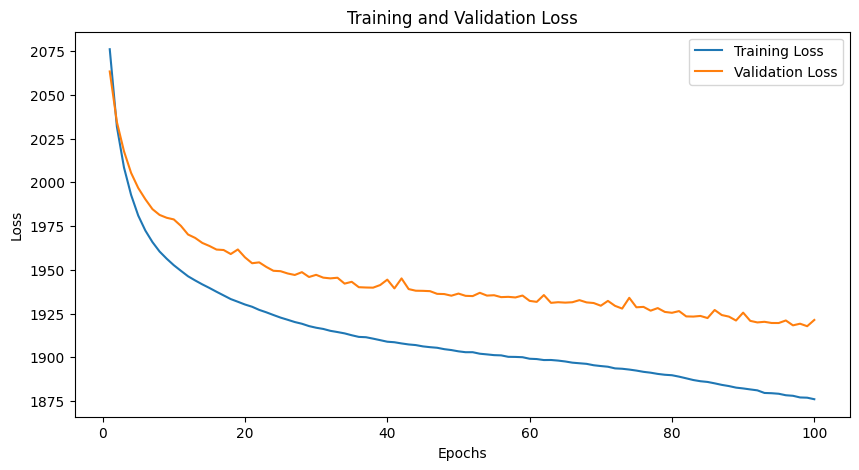

In [25]:
neural_network.plot_losses(history)

Predict

In [26]:
y_pred = neural_network.predict()

3566/3566 [==============================] - 3s 897us/step


Evaluate

In [27]:
evaluate_model(y_test, y_pred)

R2: 0.09061890887359836 
MSE: 1917.7613219432492 
MAE: 20.04578235413225 
MAPE: 850099252582223.8 
RMSE: 43.792251848280756


Show Error

In [28]:
show_error(y_test, y_pred)

,Actual,Predicted,Error
0,-5,8.0,13.0
1,-6,-7.0,1.0
2,-7,10.0,17.0
3,-4,10.0,14.0
4,10,33.0,23.0
...,...,...,...
114098,-1,8.0,9.0
114099,75,6.0,69.0
114100,-18,-10.0,8.0
114101,-17,-4.0,13.0


### ***Random Forest Model***

In [34]:
n_estimators=10
random_state=0
max_depth=None
min_samples_split=10
min_samples_leaf=5
verbose=1

Create Model

In [35]:
random_forest = RandomForest(X_train, X_test, y_train, y_test)

Run Model

In [36]:
regressor = random_forest.run_model(n_estimators=n_estimators,
                                    random_state=random_state,
                                    max_depth=None,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


Predict

In [37]:
y_pred = random_forest.predict(regressor)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [38]:
random_forest.show_predicted(y_pred)

array([[  8.10161616,  -5.        ],
       [-12.04512182,  -6.        ],
       [  6.93124931,  -7.        ],
       ...,
       [  3.06534022, -18.        ],
       [ 14.92034216, -17.        ],
       [  7.84440768,  48.        ]])

In [22]:
random_forest.show_predicted(y_pred)

array([[  4.91689741,  -5.        ],
       [ -9.75681293,  -6.        ],
       [  6.32466041,  -7.        ],
       ...,
       [  1.08957057, -18.        ],
       [ 12.17957785, -17.        ],
       [  7.50721771,  48.        ]])

Evaluate Model

In [39]:
evaluate_model(y_pred,y_test)

R2: -3.480438931439047 
MSE: 1795.9333513063243 
MAE: 18.862046181592724 
MAPE: 10.968283835473251 
RMSE: 42.37845385695807


In [23]:
evaluate_model(y_pred,y_test)

R2: -3.741470394424847 
MSE: 1765.7933636474445 
MAE: 18.53623668366497 
MAPE: 15.739907449907829 
RMSE: 42.021344143749666


Feature Importances

In [24]:
feature_importance_df = random_forest.feature_importances(regressor)
feature_importance_df

,Feature,Importance
133,Humidity,0.119288
134,Wind Speed,0.110384
131,Temperature,0.100944
135,Pressure,0.098829
136,Origin_Dubai_Distance,0.081354
...,...,...
36,Origin_encoded_EGKK,0.000149
46,Origin_encoded_LFPG,0.000148
11,Airline_encoded_MS,0.000126
39,Origin_encoded_FACT,0.000082


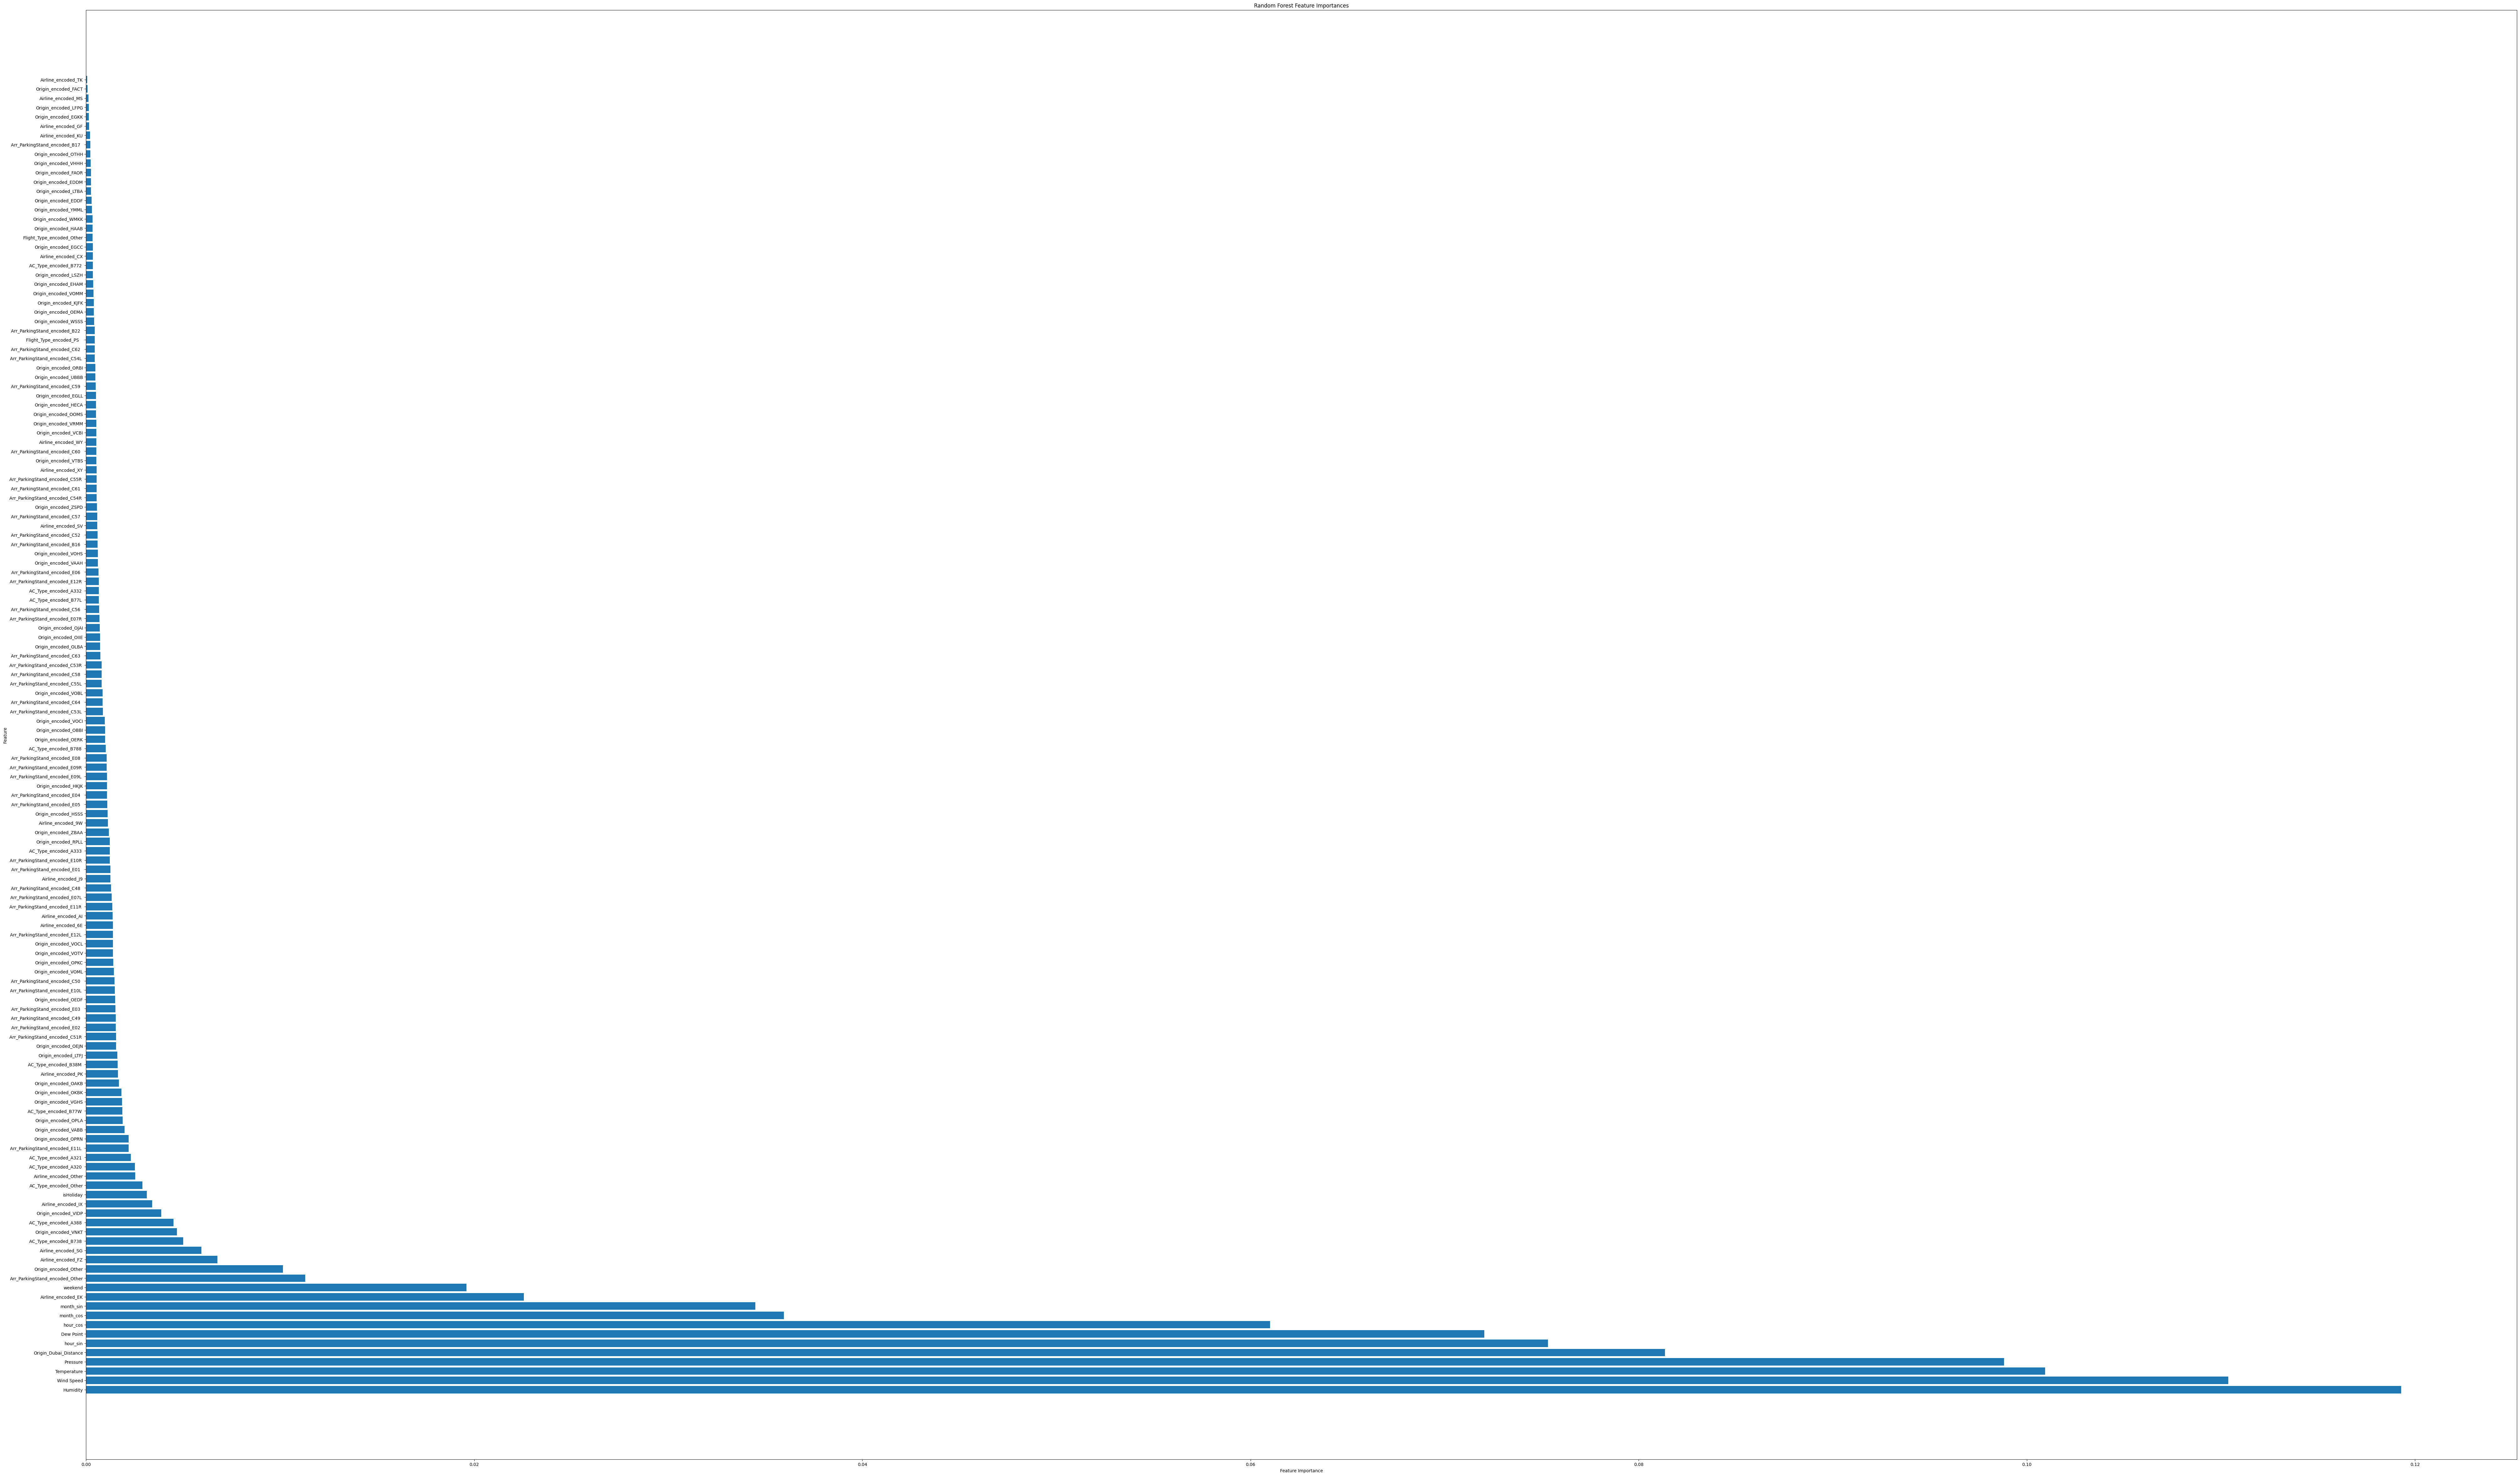

In [25]:
random_forest.plot_feature_importances(feature_importance_df, figsize=(100, 60))

### ***Linear Regression Model***

In [40]:
from sklearn.linear_model import Lasso

linear_model = Lasso(alpha=100, random_state=0)
linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [41]:
evaluate_model(y_pred, y_test)

R2: -3.480438931439047 
MSE: 1795.9333513063243 
MAE: 18.862046181592724 
MAPE: 10.968283835473251 
RMSE: 42.37845385695807
